In [ ]:
!pip install alpha_vantage
!pip install --upgrade statsmodels
!pip install prophet

In [ ]:
import os 
import sys
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
import warnings as wa
wa.warn_explicit = wa.warn = lambda *_, **__: None

# The google drive mounting is for using local library

In [ ]:
try: 
    # Mount your google drive in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    # Insert the directory to syspath
    sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
except:
    pass

Import local time_series library

In [ ]:
from time_series_utils import timeseries_evaluation_metrics_func, \
                          create_proph_train_test, find_best_Prophet_model, \
                          find_best_ETS_model, find_best_ARIMA_model, find_best_SARIMAX_model,\
                          load_hyperparam, save_hyperparam

## Real GDP China

In [ ]:
suffix = 'china_real_GDP'

In [ ]:
df5 = pd.read_csv(
	'https://www.econdb.com/api/series/RGDPCN/?format=csv',
	index_col='Date', parse_dates=['Date'])
df5.columns, df5.dtypes

(Index(['RGDPCN'], dtype='object'),
 RGDPCN    int64
 dtype: object)

In [ ]:
df5.shape

(61, 1)

In [ ]:
df5.head()

RGDPCN
Date              
2007-01-01   53480
2007-04-01   59217
2007-07-01   61099
2007-10-01   67399
2008-01-01   59640

In [ ]:
value_col = 'GDP'

In [ ]:
df5.columns = [value_col]

In [ ]:
df5.head()

GDP
Date             
2007-01-01  53480
2007-04-01  59217
2007-07-01  61099
2007-10-01  67399
2008-01-01  59640

<AxesSubplot:xlabel='Date'>

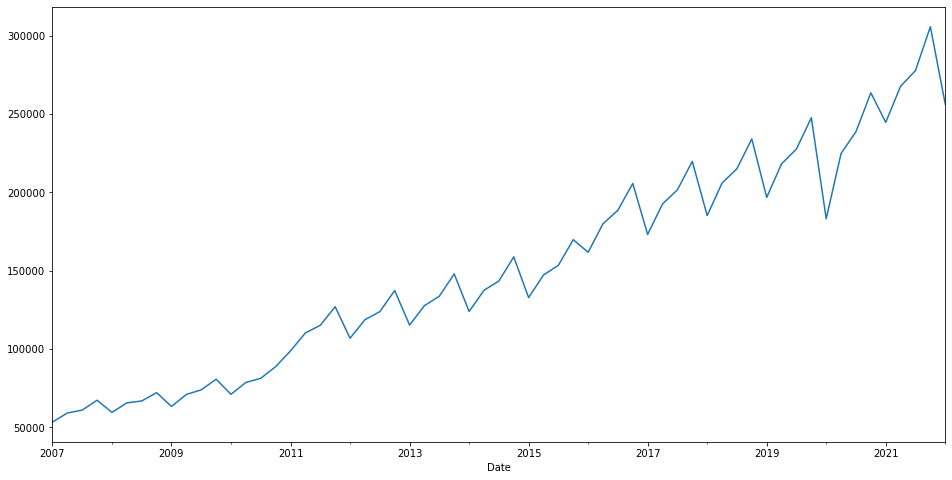

In [ ]:
df5[value_col].plot(figsize=(16,8))

In [ ]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2019,10,1)
test_dataset_end = datetime(2021,4,1)

In [ ]:
train_data = df5[:train_dataset_end]
test_data = df5[train_dataset_end+timedelta(days=91):test_dataset_end]

In [ ]:
prediction_length = len(test_data)
prediction_length

6

Save train_data and test_data to local storage.

In [ ]:
train_data_filename = 'train_data_{suffix}.csv'
test_data_filename = 'test_data_{suffix}.csv'

In [ ]:
train_data.to_csv(train_data_filename, encoding='utf-8')
test_data.to_csv(test_data_filename, encoding='utf-8')

Reload train_data and test_data from local storage 

In [ ]:
train_data = pd.read_csv(train_data_filename, parse_dates=['Date'], index_col='Date')
train_data = pd.read_csv(train_data_filename, parse_dates=['Date'], index_col='Date')

In [ ]:
train2_data = train_data[:-(prediction_length)]
val_data = train_data[-(prediction_length):]

In [ ]:
prediction_length, len(val_data), len(train_data), len(train2_data)

(6, 6, 52, 46)

In [ ]:
test_data

GDP
Date              
2020-01-01  183178
2020-04-01  224847
2020-07-01  238702
2020-10-01  263509
2021-01-01  244679
2021-04-01  267701

In [ ]:
# Value Columns to be used in all models tuning
value_col = 'GDP'

In [ ]:
# freq and date_col for Prophet
ph_freq='QS'
ph_date_col='Date'

## Holt Winters ExponentialSmoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Find hyperparameters using train2 and validation data.

In [ ]:
best_ETS_RMSE_model, best_RMSE, best_ETS_RMSE_params, best_ETS_WMAPE_model, best_WMAPE, best_ETS_WMAPE_params\
  = find_best_ETS_model(train2_data, val_data, value_col=value_col, seasonal_periods=[2, 4])

In [ ]:
best_WMAPE, best_ETS_WMAPE_params

(0.011180885362346536, ('add', 'mul', 4))

In [ ]:
best_RMSE, best_ETS_RMSE_params

(2934.972693088092, ('add', 'mul', 4))

We retrain with whole train data.

In [ ]:
trend, seasonal, seasonal_period = best_ETS_RMSE_params

ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()

In [ ]:
test_pred_ETS = ETS_model_updated.forecast(prediction_length)
test_pred_ETS

2020-01-01    211432.618038
2020-04-01    235513.187120
2020-07-01    244268.590087
2020-10-01    262829.240108
2021-01-01    224616.577230
2021-04-01    249973.282956
Freq: QS-OCT, dtype: float64

In [ ]:
test_data['Predicted_ETS'] = test_pred_ETS

<AxesSubplot:xlabel='Date'>

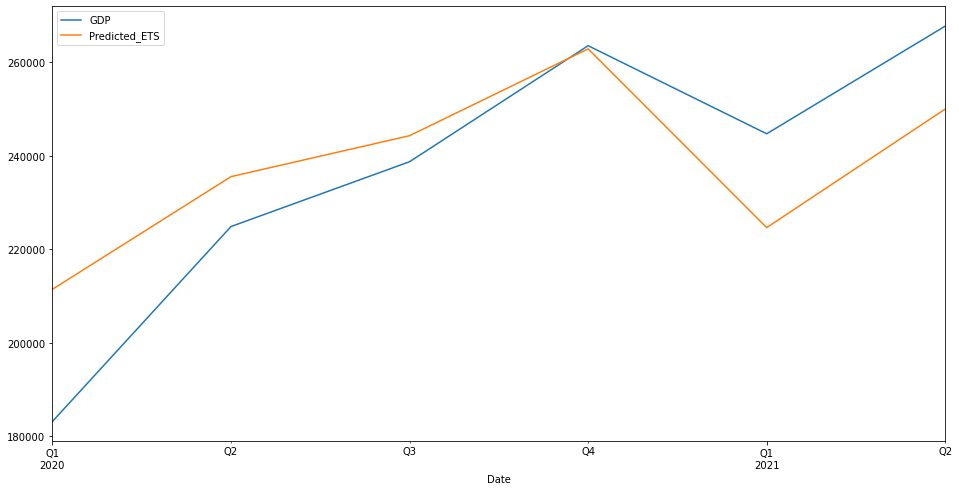

In [ ]:
test_data[[value_col, 'Predicted_ETS']].plot(figsize=(16,8))

## ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model_filename = f"arima_{suffix}_hyper_params"

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(arima_model_filename)
except:
    pass 

In [ ]:
# # force hyperparameters calculation 
# best_params = None

We search best hyperparameters using train2 and validation data.

In [ ]:
best_ARIMA_RMSE_model, best_RMSE, best_pdq_RMSE, best_ARIMA_WMAPE_model, best_WMAPE, best_pdq_WMAPE\
 = find_best_ARIMA_model(train2_data, val_data, value_col=value_col, best_params=best_params)

In [ ]:
best_pdq_RMSE, best_RMSE

((5, 0, 11), 3978.7771960076134)

In [ ]:
# save hyperparams to file 
save_hyperparam(arima_model_filename, best_pdq_RMSE)

In [ ]:
best_pdq_WMAPE, best_WMAPE

((5, 0, 11), 0.01710607495294284)


best_pdq_WMAPE, best_WMAPE

((9, 1, 9), 0.013246892316831446)

Retrain model with whole train data.

In [ ]:
model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_RMSE).fit()

In [ ]:
test_pred_arima = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_ARIMA'] = test_pred_arima

<AxesSubplot:xlabel='Date'>

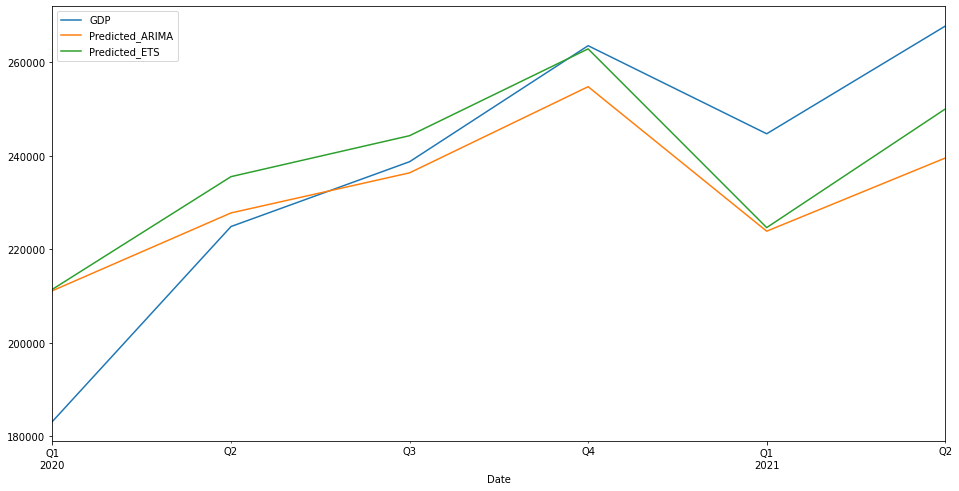

In [ ]:
test_data[[value_col, 'Predicted_ARIMA', 'Predicted_ETS']].plot(figsize=(16,8))

## SARIMAX

In [ ]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
sarimax_model_filename = f"sarimax_{suffix}_hyper_params"

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(sarimax_model_filename)
except:
    pass 

In [ ]:
best_params

(0, 0, 0, 4)

In [ ]:
best_pdq = best_pdq_RMSE
season_period = best_ETS_RMSE_params[2]

In [ ]:
# # force hyperparameter search
# best_params = None

We find hyperparameters with train2 and validation data. 

In [ ]:
best_SARIMAX_model, best_RMSE, best_PDQS = find_best_SARIMAX_model(train2_data, val_data, best_pdq, value_col=value_col,\
                                                                  season_period=season_period, best_params=best_params)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70222D+19    |proj g|=  6.52666D+24

At iterate    5    f=  1.29325D+13    |proj g|=  1.00036D+15

At iterate   10    f=  1.66497D+12    |proj g|=  4.81663D+13

At iterate   15    f=  1.56407D+11    |proj g|=  1.83033D+12

At iterate   20    f=  7.73156D+09    |proj g|=  4.90072D+10

At iterate   25    f=  5.26235D+08    |proj g|=  2.20668D+09

At iterate   30    f=  4.94073D+07    |proj g|=  9.99123D+07

At iterate   35    f=  5.46269D+06    |proj g|=  5.02643D+06

At iterate   40    f=  7.68605D+05    |proj g|=  1.04308D+06

At iterate   45    f=  1.54234D+05    |proj g|=  1.76285D+05

At iterate   50    f=  5.22602D+04    |proj g|=  5.22865D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [ ]:
pred_test_SARIMAX = best_SARIMAX_model.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
best_RMSE, best_PDQS

(14206.070094579733, (0, 0, 0, 4))

In [ ]:
# save best hyperparams to file 
save_hyperparam(sarimax_model_filename, best_PDQS)

We train the model with full train data.

In [ ]:
model_SARIMAX = SARIMAX(train_data[value_col], order=best_pdq_RMSE, seasonal_order=best_PDQS).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23469D+02    |proj g|=  1.76570D+03

At iterate    5    f=  1.34186D+01    |proj g|=  3.74330D+00

At iterate   10    f=  1.15453D+01    |proj g|=  7.46715D-01


 This problem is unconstrained.



At iterate   15    f=  1.11437D+01    |proj g|=  3.52510D-01

At iterate   20    f=  1.10241D+01    |proj g|=  4.82301D-01

At iterate   25    f=  1.09051D+01    |proj g|=  1.27496D+00

At iterate   30    f=  1.07967D+01    |proj g|=  2.61043D-01

At iterate   35    f=  1.07399D+01    |proj g|=  1.40593D+00

At iterate   40    f=  1.06736D+01    |proj g|=  2.63087D-01

At iterate   45    f=  1.06553D+01    |proj g|=  1.70937D-01

At iterate   50    f=  1.06434D+01    |proj g|=  4.03213D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   4.032D-01   1.064D+01
  F =   10.6433852209

In [ ]:
pred_test_SARIMAX = model_SARIMAX.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_SARIMAX'] = pred_test_SARIMAX

<AxesSubplot:xlabel='Date'>

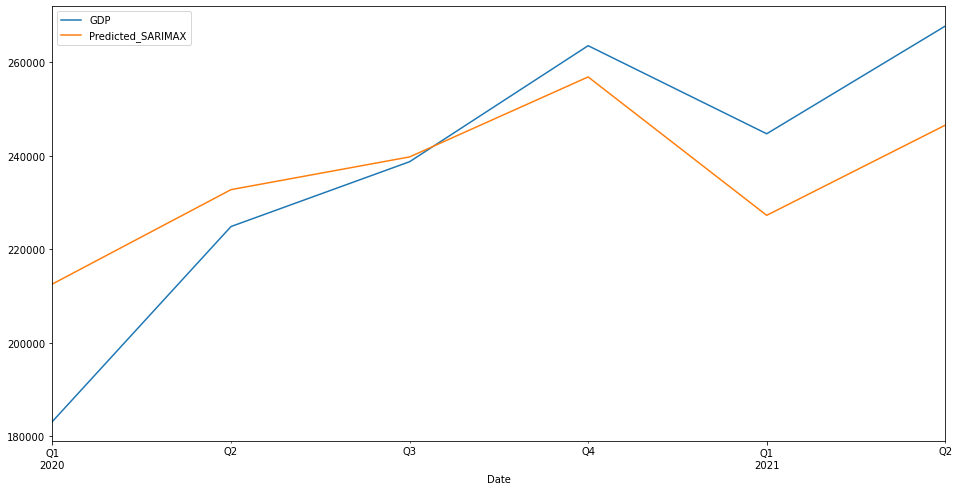

In [ ]:
test_data[[value_col, 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Prophet

In [ ]:
from prophet import Prophet

In [ ]:
proph_train, proph_test = create_proph_train_test(train_data, test_data, date_col='Date', value_col=value_col)

In [ ]:
prophet_model_filename = f"prophet_{suffix}_hyper_params"

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(prophet_model_filename)
except:
    pass 

In [ ]:
# # force hyperparameter search 
# best_params = None

Find the best hyperparameters with train2 and validation data. 

In [ ]:
best_Prophet_RMSE_model, best_RMSE, best_Prophet_RMSE_params, best_Prophet_WMAPE_model, best_WMAPE, best_Prophet_WMAPE_params\
 = find_best_Prophet_model(proph_train, proph_test, test_data, value_col=value_col,freq=ph_freq, best_params=best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = 29.9903
Iteration  1. Log joint probability =    61.1076. Improved by 31.1173.
Iteration  2. Log joint probability =    103.747. Improved by 42.6396.
Iteration  3. Log joint probability =    123.736. Improved by 19.9887.
Iteration  4. Log joint probability =    145.461. Improved by 21.7253.
Iteration  5. Log joint probability =    146.185. Improved by 0.723866.
Iteration  6. Log joint probability =    146.338. Improved by 0.152498.
Iteration  7. Log joint probability =    146.361. Improved by 0.0236562.
Iteration  8. Log joint probability =    146.533. Improved by 0.172078.
Iteration  9. Log joint probability =    146.613. Improved by 0.0801723.
Iteration 10. Log joint probability =    146.732. Improved by 0.118039.
Iteration 11. Log joint probability =    146.911. Improved by 0.179585.
Iteration 12. Log joint probability =    147.007. Improved by 0.0961515.
Iteration 13. Log joint probability =    147.253. Improved by 0.245543.
Iteration 14. Log joint 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6012009100931727

Initial log joint probability = 29.9903
Iteration  1. Log joint probability =    61.6712. Improved by 31.6809.
Iteration  2. Log joint probability =    93.0405. Improved by 31.3694.
Iteration  3. Log joint probability =    128.547. Improved by 35.5065.
Iteration  4. Log joint probability =    130.401. Improved by 1.85396.
Iteration  5. Log joint probability =    139.142. Improved by 8.74144.
Iteration  6. Log joint probability =    139.243. Improved by 0.100407.
Iteration  7. Log joint probability =    139.884. Improved by 0.641217.
Iteration  8. Log joint probability =    139.971. Improved by 0.0873087.
Iteration  9. Log joint probability =    140.231. Improved by 0.260017.
Iteration 10. Log joint probability =    140.296. Improved by 0.0648419.
Iteration 11. Log joint probability =    140.401. Improved by 0.104557.
Iteration 12. Log joint probability =     140.69. Improved by 0.288864.
Iteration 13. Log joint probability =    145.691. Improv

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6735699341930174

Initial log joint probability = -29.9243
Iteration  1. Log joint probability =    55.0269. Improved by 84.9512.
Iteration  2. Log joint probability =    105.574. Improved by 50.5475.
Iteration  3. Log joint probability =    132.996. Improved by 27.4213.
Iteration  4. Log joint probability =    149.359. Improved by 16.363.
Iteration  5. Log joint probability =    151.614. Improved by 2.25551.
Iteration  6. Log joint probability =    151.969. Improved by 0.355152.
Iteration  7. Log joint probability =    152.068. Improved by 0.0984505.
Iteration  8. Log joint probability =    152.126. Improved by 0.05807.
Iteration  9. Log joint probability =    152.169. Improved by 0.0435515.
Iteration 10. Log joint probability =    152.211. Improved by 0.0415714.
Iteration 11. Log joint probability =    152.221. Improved by 0.0102348.
Iteration 12. Log joint probability =     152.26. Improved by 0.038756.
Iteration 13. Log joint probability =    152.323. Impro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6030287369001922

Initial log joint probability = -29.9243
Iteration  1. Log joint probability =    68.6168. Improved by 98.5411.
Iteration  2. Log joint probability =    91.7973. Improved by 23.1805.
Iteration  3. Log joint probability =    114.105. Improved by 22.3077.
Iteration  4. Log joint probability =    122.025. Improved by 7.92042.
Iteration  5. Log joint probability =    147.103. Improved by 25.0776.
Iteration  6. Log joint probability =    147.204. Improved by 0.101276.
Iteration  7. Log joint probability =     147.26. Improved by 0.0560031.
Iteration  8. Log joint probability =    147.364. Improved by 0.103467.
Iteration  9. Log joint probability =    147.462. Improved by 0.0985216.
Iteration 10. Log joint probability =    147.574. Improved by 0.111268.
Iteration 11. Log joint probability =    147.664. Improved by 0.0901897.
Iteration 12. Log joint probability =    147.791. Improved by 0.12744.
Iteration 13. Log joint probability =    154.494. Impro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6674721058986977

Initial log joint probability = -62.1131
Iteration  1. Log joint probability =    54.6755. Improved by 116.789.
Iteration  2. Log joint probability =    104.783. Improved by 50.1074.
Iteration  3. Log joint probability =    132.203. Improved by 27.4198.
Iteration  4. Log joint probability =    145.372. Improved by 13.1698.
Iteration  5. Log joint probability =    148.291. Improved by 2.91879.
Iteration  6. Log joint probability =    148.905. Improved by 0.613794.
Iteration  7. Log joint probability =    149.014. Improved by 0.108611.
Iteration  8. Log joint probability =    149.086. Improved by 0.0718919.
Iteration  9. Log joint probability =    149.208. Improved by 0.122863.
Iteration 10. Log joint probability =    149.239. Improved by 0.0308943.
Iteration 11. Log joint probability =    149.334. Improved by 0.0952034.
Iteration 12. Log joint probability =     149.38. Improved by 0.0456195.
Iteration 13. Log joint probability =    149.453. Imp

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.602865981887716

Initial log joint probability = -62.1131
Iteration  1. Log joint probability =    68.4456. Improved by 130.559.
Iteration  2. Log joint probability =     91.311. Improved by 22.8654.
Iteration  3. Log joint probability =     104.81. Improved by 13.4989.
Iteration  4. Log joint probability =    138.887. Improved by 34.0774.
Iteration  5. Log joint probability =    140.425. Improved by 1.53743.
Iteration  6. Log joint probability =    140.439. Improved by 0.0138916.
Iteration  7. Log joint probability =    140.524. Improved by 0.0853625.
Iteration  8. Log joint probability =    140.595. Improved by 0.0713911.
Iteration  9. Log joint probability =    140.974. Improved by 0.378157.
Iteration 10. Log joint probability =    141.096. Improved by 0.122935.
Iteration 11. Log joint probability =    141.602. Improved by 0.505976.
Iteration 12. Log joint probability =    142.698. Improved by 1.09579.
Iteration 13. Log joint probability =    143.339. Improv

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6827768161306793

Initial log joint probability = 12.6616
Iteration  1. Log joint probability =    61.1078. Improved by 48.4461.
Iteration  2. Log joint probability =    103.709. Improved by 42.601.
Iteration  3. Log joint probability =    125.268. Improved by 21.5592.
Iteration  4. Log joint probability =    146.911. Improved by 21.6428.
Iteration  5. Log joint probability =     146.93. Improved by 0.0196481.
Iteration  6. Log joint probability =    146.982. Improved by 0.0514563.
Iteration  7. Log joint probability =    147.029. Improved by 0.0475264.
Iteration  8. Log joint probability =    148.012. Improved by 0.98297.
Iteration  9. Log joint probability =    148.013. Improved by 0.00111019.
Iteration 10. Log joint probability =    148.059. Improved by 0.0453326.
Iteration 11. Log joint probability =    148.118. Improved by 0.0596748.
Iteration 12. Log joint probability =    148.696. Improved by 0.577463.
Iteration 13. Log joint probability =    149.196. Im

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6067830272783922

Initial log joint probability = 12.6616
Iteration  1. Log joint probability =    61.6713. Improved by 49.0097.
Iteration  2. Log joint probability =    93.0736. Improved by 31.4022.
Iteration  3. Log joint probability =    128.423. Improved by 35.3499.
Iteration  4. Log joint probability =     131.14. Improved by 2.71662.
Iteration  5. Log joint probability =    145.365. Improved by 14.2248.
Iteration  6. Log joint probability =    148.555. Improved by 3.18991.
Iteration  7. Log joint probability =    153.092. Improved by 4.53748.
Iteration  8. Log joint probability =    153.732. Improved by 0.640133.
Iteration  9. Log joint probability =    154.632. Improved by 0.899711.
Iteration 10. Log joint probability =    154.866. Improved by 0.233854.
Iteration 11. Log joint probability =    155.267. Improved by 0.40123.
Iteration 12. Log joint probability =    155.403. Improved by 0.135386.
Iteration 13. Log joint probability =    155.864. Improved by

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6576047759141603

Initial log joint probability = -47.253
Iteration  1. Log joint probability =     55.027. Improved by 102.28.
Iteration  2. Log joint probability =    105.587. Improved by 50.5597.
Iteration  3. Log joint probability =    133.805. Improved by 28.2185.
Iteration  4. Log joint probability =    145.532. Improved by 11.7271.
Iteration  5. Log joint probability =    145.556. Improved by 0.0237143.
Iteration  6. Log joint probability =    145.579. Improved by 0.0234853.
Iteration  7. Log joint probability =    145.595. Improved by 0.015861.
Iteration  8. Log joint probability =    145.757. Improved by 0.162018.
Iteration  9. Log joint probability =    145.882. Improved by 0.124771.
Iteration 10. Log joint probability =    146.006. Improved by 0.123506.
Iteration 11. Log joint probability =    146.334. Improved by 0.328161.
Iteration 12. Log joint probability =    147.026. Improved by 0.6926.
Iteration 13. Log joint probability =    147.538. Improved

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.611711599763705

Initial log joint probability = -47.253
Iteration  1. Log joint probability =    68.6169. Improved by 115.87.
Iteration  2. Log joint probability =    91.7472. Improved by 23.1302.
Iteration  3. Log joint probability =    114.701. Improved by 22.954.
Iteration  4. Log joint probability =     120.69. Improved by 5.98869.
Iteration  5. Log joint probability =     133.37. Improved by 12.6804.
Iteration  6. Log joint probability =    133.491. Improved by 0.12115.
Iteration  7. Log joint probability =    133.726. Improved by 0.235017.
Iteration  8. Log joint probability =    133.751. Improved by 0.0251021.
Iteration  9. Log joint probability =    134.002. Improved by 0.250523.
Iteration 10. Log joint probability =    134.097. Improved by 0.0950288.
Iteration 11. Log joint probability =    134.951. Improved by 0.853674.
Iteration 12. Log joint probability =    136.081. Improved by 1.13021.
Iteration 13. Log joint probability =    136.308. Improved by

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6743386957914707

Initial log joint probability = -79.4418
Iteration  1. Log joint probability =    54.6756. Improved by 134.117.
Iteration  2. Log joint probability =     104.79. Improved by 50.114.
Iteration  3. Log joint probability =    132.516. Improved by 27.7261.
Iteration  4. Log joint probability =    145.362. Improved by 12.8464.
Iteration  5. Log joint probability =    145.373. Improved by 0.0105019.
Iteration  6. Log joint probability =    145.457. Improved by 0.0848065.
Iteration  7. Log joint probability =    145.538. Improved by 0.0805813.
Iteration  8. Log joint probability =    145.602. Improved by 0.0636026.
Iteration  9. Log joint probability =    145.805. Improved by 0.203706.
Iteration 10. Log joint probability =    146.097. Improved by 0.291428.
Iteration 11. Log joint probability =    146.115. Improved by 0.0181809.
Iteration 12. Log joint probability =    146.225. Improved by 0.109617.
Iteration 13. Log joint probability =    146.571. Im

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6080354569100243

Initial log joint probability = -79.4418
Iteration  1. Log joint probability =    68.4458. Improved by 147.888.
Iteration  2. Log joint probability =    91.2508. Improved by 22.8049.
Iteration  3. Log joint probability =     106.26. Improved by 15.009.
Iteration  4. Log joint probability =    139.454. Improved by 33.1941.
Iteration  5. Log joint probability =    139.495. Improved by 0.0415491.
Iteration  6. Log joint probability =    156.165. Improved by 16.6698.
Iteration  7. Log joint probability =     156.21. Improved by 0.0443522.
Iteration  8. Log joint probability =    156.387. Improved by 0.177695.
Iteration  9. Log joint probability =    156.514. Improved by 0.12633.
Iteration 10. Log joint probability =    156.578. Improved by 0.0640573.
Iteration 11. Log joint probability =    160.025. Improved by 3.44771.
Iteration 12. Log joint probability =    161.514. Improved by 1.48873.
Iteration 13. Log joint probability =    163.116. Improved

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6901809698334478

Initial log joint probability = -14.8037
Iteration  1. Log joint probability =    61.1085. Improved by 75.9122.
Iteration  2. Log joint probability =    103.678. Improved by 42.57.
Iteration  3. Log joint probability =    103.679. Improved by 0.000790661.
Iteration  4. Log joint probability =    103.707. Improved by 0.0274429.
Iteration  5. Log joint probability =    113.458. Improved by 9.75167.
Iteration  6. Log joint probability =    127.155. Improved by 13.6966.
Iteration  7. Log joint probability =    133.594. Improved by 6.43873.
Iteration  8. Log joint probability =    146.867. Improved by 13.2737.
Iteration  9. Log joint probability =     150.65. Improved by 3.78232.
Iteration 10. Log joint probability =    152.446. Improved by 1.79673.
Iteration 11. Log joint probability =    158.758. Improved by 6.31197.
Iteration 12. Log joint probability =    161.897. Improved by 3.13899.
Iteration 13. Log joint probability =    164.205. Improved b

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5978955734907946

Initial log joint probability = -14.8037
Iteration  1. Log joint probability =     61.672. Improved by 76.4756.
Iteration  2. Log joint probability =    92.8986. Improved by 31.2267.
Iteration  3. Log joint probability =    128.029. Improved by 35.1307.
Iteration  4. Log joint probability =    139.496. Improved by 11.4665.
Iteration  5. Log joint probability =    141.998. Improved by 2.50198.
Iteration  6. Log joint probability =    153.329. Improved by 11.3307.
Iteration  7. Log joint probability =    176.694. Improved by 23.3651.
Iteration  8. Log joint probability =    189.481. Improved by 12.7869.
Iteration  9. Log joint probability =    194.041. Improved by 4.5604.
Iteration 10. Log joint probability =    194.399. Improved by 0.357948.
Iteration 11. Log joint probability =    195.504. Improved by 1.10474.
Iteration 12. Log joint probability =    197.055. Improved by 1.55153.
Iteration 13. Log joint probability =    197.235. Improved by 0.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6632857902753189

Initial log joint probability = -74.7183
Iteration  1. Log joint probability =    55.0277. Improved by 129.746.
Iteration  2. Log joint probability =    105.733. Improved by 50.7049.
Iteration  3. Log joint probability =     105.74. Improved by 0.00700504.
Iteration  4. Log joint probability =    105.774. Improved by 0.0343263.
Iteration  5. Log joint probability =    107.477. Improved by 1.70312.
Iteration  6. Log joint probability =    115.449. Improved by 7.97162.
Iteration  7. Log joint probability =    123.036. Improved by 7.58744.
Iteration  8. Log joint probability =    140.928. Improved by 17.8921.
Iteration  9. Log joint probability =     142.98. Improved by 2.05172.
Iteration 10. Log joint probability =    153.954. Improved by 10.9744.
Iteration 11. Log joint probability =    154.357. Improved by 0.402612.
Iteration 12. Log joint probability =    159.546. Improved by 5.18916.
Iteration 13. Log joint probability =    159.586. Improved

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6028024009673132

Initial log joint probability = -74.7183
Iteration  1. Log joint probability =    68.6176. Improved by 143.336.
Iteration  2. Log joint probability =    91.4204. Improved by 22.8027.
Iteration  3. Log joint probability =     112.75. Improved by 21.3294.
Iteration  4. Log joint probability =    112.764. Improved by 0.014258.
Iteration  5. Log joint probability =    112.793. Improved by 0.0289809.
Iteration  6. Log joint probability =      112.8. Improved by 0.00736466.
Iteration  7. Log joint probability =    112.814. Improved by 0.0133463.
Iteration  8. Log joint probability =    112.889. Improved by 0.0751947.
Iteration  9. Log joint probability =    112.983. Improved by 0.0944051.
Iteration 10. Log joint probability =    113.125. Improved by 0.141811.
Iteration 11. Log joint probability =     113.29. Improved by 0.164538.
Iteration 12. Log joint probability =    113.515. Improved by 0.224939.
Iteration 13. Log joint probability =    114.952.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6841687239689045

Initial log joint probability = -106.907
Iteration  1. Log joint probability =    54.6763. Improved by 161.583.
Iteration  2. Log joint probability =     104.92. Improved by 50.2435.
Iteration  3. Log joint probability =    104.926. Improved by 0.00611749.
Iteration  4. Log joint probability =    104.961. Improved by 0.0352958.
Iteration  5. Log joint probability =    105.963. Improved by 1.00166.
Iteration  6. Log joint probability =    106.299. Improved by 0.336079.
Iteration  7. Log joint probability =     124.48. Improved by 18.1811.
Iteration  8. Log joint probability =     141.74. Improved by 17.2601.
Iteration  9. Log joint probability =    156.459. Improved by 14.7191.
Iteration 10. Log joint probability =    158.353. Improved by 1.89415.
Iteration 11. Log joint probability =    159.127. Improved by 0.773722.
Iteration 12. Log joint probability =    159.145. Improved by 0.0181565.
Iteration 13. Log joint probability =    159.234. Impro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6050445185715912

Initial log joint probability = -106.907
Iteration  1. Log joint probability =    68.4467. Improved by 175.354.
Iteration  2. Log joint probability =    90.9218. Improved by 22.4751.
Iteration  3. Log joint probability =     103.68. Improved by 12.7583.
Iteration  4. Log joint probability =    103.697. Improved by 0.0168831.
Iteration  5. Log joint probability =    103.744. Improved by 0.0469428.
Iteration  6. Log joint probability =     103.75. Improved by 0.00616494.
Iteration  7. Log joint probability =    103.755. Improved by 0.0044036.
Iteration  8. Log joint probability =    103.803. Improved by 0.0480181.
Iteration  9. Log joint probability =    103.815. Improved by 0.0127526.
Iteration 10. Log joint probability =    103.829. Improved by 0.0134502.
Iteration 11. Log joint probability =    103.846. Improved by 0.0169281.
Iteration 12. Log joint probability =     106.44. Improved by 2.59396.
Iteration 13. Log joint probability =    106.82

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.7052193866714463

Initial log joint probability = -27.5743
Iteration  1. Log joint probability =    61.1093. Improved by 88.6836.
Iteration  2. Log joint probability =    103.674. Improved by 42.5646.
Iteration  3. Log joint probability =     103.68. Improved by 0.00629603.
Iteration  4. Log joint probability =    103.683. Improved by 0.00263116.
Iteration  5. Log joint probability =    103.746. Improved by 0.0634515.
Iteration  6. Log joint probability =    103.801. Improved by 0.0542693.
Iteration  7. Log joint probability =    103.852. Improved by 0.0513717.
Iteration  8. Log joint probability =    103.898. Improved by 0.0461571.
Iteration  9. Log joint probability =    103.951. Improved by 0.0528994.
Iteration 10. Log joint probability =    103.996. Improved by 0.0450061.
Iteration 11. Log joint probability =     104.05. Improved by 0.0543242.
Iteration 12. Log joint probability =    104.094. Improved by 0.0439367.
Iteration 13. Log joint probability =    1

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5967343775350176

Initial log joint probability = -27.5743
Iteration  1. Log joint probability =    61.6726. Improved by 89.2469.
Iteration  2. Log joint probability =    92.7716. Improved by 31.0991.
Iteration  3. Log joint probability =    127.614. Improved by 34.8424.
Iteration  4. Log joint probability =    130.044. Improved by 2.42975.
Iteration  5. Log joint probability =    131.054. Improved by 1.01043.
Iteration  6. Log joint probability =    143.688. Improved by 12.634.
Iteration  7. Log joint probability =    175.997. Improved by 32.3086.
Iteration  8. Log joint probability =    194.097. Improved by 18.0999.
Iteration  9. Log joint probability =    197.867. Improved by 3.77034.
Iteration 10. Log joint probability =    205.266. Improved by 7.39887.
Iteration 11. Log joint probability =    206.291. Improved by 1.02498.
Iteration 12. Log joint probability =    206.881. Improved by 0.590488.
Iteration 13. Log joint probability =    207.708. Improved by 0.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6656346077544928

Initial log joint probability = -87.489
Iteration  1. Log joint probability =    55.0283. Improved by 142.517.
Iteration  2. Log joint probability =    105.847. Improved by 50.819.
Iteration  3. Log joint probability =    105.852. Improved by 0.00483077.
Iteration  4. Log joint probability =    105.924. Improved by 0.0723546.
Iteration  5. Log joint probability =    105.993. Improved by 0.0689088.
Iteration  6. Log joint probability =        106. Improved by 0.00701841.
Iteration  7. Log joint probability =    106.024. Improved by 0.0240629.
Iteration  8. Log joint probability =    117.871. Improved by 11.8468.
Iteration  9. Log joint probability =    121.771. Improved by 3.89935.
Iteration 10. Log joint probability =    124.754. Improved by 2.98392.
Iteration 11. Log joint probability =    124.773. Improved by 0.0180558.
Iteration 12. Log joint probability =    127.224. Improved by 2.45135.
Iteration 13. Log joint probability =    137.374. Im

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5959487820406459

Initial log joint probability = -87.489
Iteration  1. Log joint probability =    68.6184. Improved by 156.107.
Iteration  2. Log joint probability =    91.1816. Improved by 22.5632.
Iteration  3. Log joint probability =    92.0728. Improved by 0.89119.
Iteration  4. Log joint probability =    92.9919. Improved by 0.919164.
Iteration  5. Log joint probability =    93.4486. Improved by 0.456625.
Iteration  6. Log joint probability =    94.2574. Improved by 0.808875.
Iteration  7. Log joint probability =    94.9131. Improved by 0.655677.
Iteration  8. Log joint probability =    95.3355. Improved by 0.422353.
Iteration  9. Log joint probability =    95.6719. Improved by 0.336459.
Iteration 10. Log joint probability =    96.1864. Improved by 0.5145.
Iteration 11. Log joint probability =    96.3978. Improved by 0.211349.
Iteration 12. Log joint probability =    99.2151. Improved by 2.81734.
Iteration 13. Log joint probability =    103.256. Improved 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.689612266314524

Initial log joint probability = -119.678
Iteration  1. Log joint probability =    54.6769. Improved by 174.355.
Iteration  2. Log joint probability =    105.024. Improved by 50.3475.
Iteration  3. Log joint probability =    105.042. Improved by 0.0179817.
Iteration  4. Log joint probability =    105.091. Improved by 0.0487027.
Iteration  5. Log joint probability =    105.135. Improved by 0.0438881.
Iteration  6. Log joint probability =    105.141. Improved by 0.0056703.
Iteration  7. Log joint probability =    105.151. Improved by 0.0104855.
Iteration  8. Log joint probability =     105.17. Improved by 0.0185298.
Iteration  9. Log joint probability =    105.205. Improved by 0.0351834.
Iteration 10. Log joint probability =    105.266. Improved by 0.0616474.
Iteration 11. Log joint probability =    105.313. Improved by 0.0466195.
Iteration 12. Log joint probability =    105.319. Improved by 0.00640769.
Iteration 13. Log joint probability =    105

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5991027469407392

Initial log joint probability = -119.678
Iteration  1. Log joint probability =    68.4476. Improved by 188.125.
Iteration  2. Log joint probability =    90.6884. Improved by 22.2408.
Iteration  3. Log joint probability =    91.3974. Improved by 0.70902.
Iteration  4. Log joint probability =    92.0619. Improved by 0.664459.
Iteration  5. Log joint probability =    92.2895. Improved by 0.227613.
Iteration  6. Log joint probability =    92.3158. Improved by 0.0263099.
Iteration  7. Log joint probability =    92.9971. Improved by 0.681257.
Iteration  8. Log joint probability =    93.0927. Improved by 0.0955966.
Iteration  9. Log joint probability =    93.5279. Improved by 0.435234.
Iteration 10. Log joint probability =    93.6427. Improved by 0.114751.
Iteration 11. Log joint probability =     94.082. Improved by 0.439329.
Iteration 12. Log joint probability =    94.3668. Improved by 0.284836.
Iteration 13. Log joint probability =      94.53. Imp

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.7110175151731996

Initial log joint probability = 29.9903
Iteration  1. Log joint probability =    61.1078. Improved by 31.1175.
Iteration  2. Log joint probability =    103.727. Improved by 42.6195.
Iteration  3. Log joint probability =    123.813. Improved by 20.0853.
Iteration  4. Log joint probability =    144.879. Improved by 21.066.
Iteration  5. Log joint probability =    147.725. Improved by 2.84603.
Iteration  6. Log joint probability =    147.825. Improved by 0.10073.
Iteration  7. Log joint probability =    148.023. Improved by 0.197331.
Iteration  8. Log joint probability =    148.084. Improved by 0.0611785.
Iteration  9. Log joint probability =    148.418. Improved by 0.334567.
Iteration 10. Log joint probability =    148.656. Improved by 0.237872.
Iteration 11. Log joint probability =    148.752. Improved by 0.0958132.
Iteration 12. Log joint probability =    148.809. Improved by 0.0571978.
Iteration 13. Log joint probability =    149.169. Improve

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5998151755501206

Initial log joint probability = 29.9903
Iteration  1. Log joint probability =    61.6714. Improved by 31.6811.
Iteration  2. Log joint probability =    93.0314. Improved by 31.36.
Iteration  3. Log joint probability =    128.537. Improved by 35.5058.
Iteration  4. Log joint probability =    130.565. Improved by 2.02811.
Iteration  5. Log joint probability =    137.013. Improved by 6.4481.
Iteration  6. Log joint probability =    137.441. Improved by 0.427092.
Iteration  7. Log joint probability =    137.497. Improved by 0.0567533.
Iteration  8. Log joint probability =    137.748. Improved by 0.250387.
Iteration  9. Log joint probability =    137.882. Improved by 0.134546.
Iteration 10. Log joint probability =    138.101. Improved by 0.218283.
Iteration 11. Log joint probability =    138.145. Improved by 0.0443784.
Iteration 12. Log joint probability =    138.315. Improved by 0.170537.
Iteration 13. Log joint probability =    138.824. Improved 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6735691683523155

Initial log joint probability = -29.9243
Iteration  1. Log joint probability =    55.0272. Improved by 84.9515.
Iteration  2. Log joint probability =    105.554. Improved by 50.527.
Iteration  3. Log joint probability =    133.095. Improved by 27.5409.
Iteration  4. Log joint probability =    150.322. Improved by 17.2266.
Iteration  5. Log joint probability =    152.119. Improved by 1.797.
Iteration  6. Log joint probability =    152.157. Improved by 0.0385897.
Iteration  7. Log joint probability =    152.325. Improved by 0.168033.
Iteration  8. Log joint probability =    152.375. Improved by 0.0499942.
Iteration  9. Log joint probability =    152.423. Improved by 0.0477981.
Iteration 10. Log joint probability =    152.487. Improved by 0.0638187.
Iteration 11. Log joint probability =    152.518. Improved by 0.0309916.
Iteration 12. Log joint probability =    152.526. Improved by 0.007641.
Iteration 13. Log joint probability =    152.568. Impro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6019316411294637

Initial log joint probability = -29.9243
Iteration  1. Log joint probability =     68.617. Improved by 98.5413.
Iteration  2. Log joint probability =    91.7804. Improved by 23.1634.
Iteration  3. Log joint probability =     114.14. Improved by 22.3591.
Iteration  4. Log joint probability =    121.796. Improved by 7.65682.
Iteration  5. Log joint probability =    150.633. Improved by 28.837.
Iteration  6. Log joint probability =    150.649. Improved by 0.0154136.
Iteration  7. Log joint probability =    150.753. Improved by 0.103767.
Iteration  8. Log joint probability =    150.894. Improved by 0.1419.
Iteration  9. Log joint probability =    150.967. Improved by 0.0725207.
Iteration 10. Log joint probability =    151.004. Improved by 0.0370609.
Iteration 11. Log joint probability =    151.143. Improved by 0.138584.
Iteration 12. Log joint probability =    152.436. Improved by 1.29289.
Iteration 13. Log joint probability =    152.515. Improved

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.664248042304297

Initial log joint probability = -62.1131
Iteration  1. Log joint probability =    54.6758. Improved by 116.789.
Iteration  2. Log joint probability =    104.762. Improved by 50.0867.
Iteration  3. Log joint probability =    132.222. Improved by 27.4599.
Iteration  4. Log joint probability =     148.29. Improved by 16.0678.
Iteration  5. Log joint probability =    152.215. Improved by 3.92471.
Iteration  6. Log joint probability =    152.443. Improved by 0.227779.
Iteration  7. Log joint probability =    152.472. Improved by 0.0296591.
Iteration  8. Log joint probability =    152.591. Improved by 0.119258.
Iteration  9. Log joint probability =    152.643. Improved by 0.0513001.
Iteration 10. Log joint probability =    152.666. Improved by 0.0230951.
Iteration 11. Log joint probability =    152.687. Improved by 0.0212022.
Iteration 12. Log joint probability =    152.766. Improved by 0.0791417.
Iteration 13. Log joint probability =    152.863. Imp

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6032022922822606

Initial log joint probability = -62.1131
Iteration  1. Log joint probability =    68.4459. Improved by 130.559.
Iteration  2. Log joint probability =    91.2943. Improved by 22.8484.
Iteration  3. Log joint probability =    104.844. Improved by 13.55.
Iteration  4. Log joint probability =    138.896. Improved by 34.0521.
Iteration  5. Log joint probability =    149.206. Improved by 10.3095.
Iteration  6. Log joint probability =    149.288. Improved by 0.0825031.
Iteration  7. Log joint probability =    149.297. Improved by 0.00877922.
Iteration  8. Log joint probability =    149.309. Improved by 0.0120229.
Iteration  9. Log joint probability =    149.452. Improved by 0.142599.
Iteration 10. Log joint probability =    149.575. Improved by 0.123148.
Iteration 11. Log joint probability =    150.717. Improved by 1.14174.
Iteration 12. Log joint probability =    150.831. Improved by 0.114265.
Iteration 13. Log joint probability =    150.909. Improv

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6683377426035411

Initial log joint probability = 12.6616
Iteration  1. Log joint probability =     61.108. Improved by 48.4463.
Iteration  2. Log joint probability =    103.705. Improved by 42.5967.
Iteration  3. Log joint probability =    125.188. Improved by 21.4834.
Iteration  4. Log joint probability =    146.819. Improved by 21.6309.
Iteration  5. Log joint probability =    146.854. Improved by 0.0345363.
Iteration  6. Log joint probability =    146.947. Improved by 0.0934723.
Iteration  7. Log joint probability =    147.018. Improved by 0.0708203.
Iteration  8. Log joint probability =    147.201. Improved by 0.183196.
Iteration  9. Log joint probability =    147.317. Improved by 0.116343.
Iteration 10. Log joint probability =    147.567. Improved by 0.249835.
Iteration 11. Log joint probability =    147.585. Improved by 0.0176412.
Iteration 12. Log joint probability =    147.593. Improved by 0.00829371.
Iteration 13. Log joint probability =    147.731. I

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6058697248170314

Initial log joint probability = 12.6616
Iteration  1. Log joint probability =    61.6716. Improved by 49.0099.
Iteration  2. Log joint probability =    93.0723. Improved by 31.4007.
Iteration  3. Log joint probability =    128.434. Improved by 35.3613.
Iteration  4. Log joint probability =    131.217. Improved by 2.78387.
Iteration  5. Log joint probability =    141.636. Improved by 10.4189.
Iteration  6. Log joint probability =    148.236. Improved by 6.59931.
Iteration  7. Log joint probability =    148.513. Improved by 0.276896.
Iteration  8. Log joint probability =     149.12. Improved by 0.606961.
Iteration  9. Log joint probability =    152.321. Improved by 3.20153.
Iteration 10. Log joint probability =    152.626. Improved by 0.304865.
Iteration 11. Log joint probability =    153.666. Improved by 1.04001.
Iteration 12. Log joint probability =    153.808. Improved by 0.14207.
Iteration 13. Log joint probability =    154.349. Improved by 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6579033391132393

Initial log joint probability = -47.253
Iteration  1. Log joint probability =    55.0273. Improved by 102.28.
Iteration  2. Log joint probability =    105.578. Improved by 50.5502.
Iteration  3. Log joint probability =    133.817. Improved by 28.239.
Iteration  4. Log joint probability =    145.245. Improved by 11.4286.
Iteration  5. Log joint probability =    145.251. Improved by 0.00573836.
Iteration  6. Log joint probability =    145.328. Improved by 0.0772156.
Iteration  7. Log joint probability =    145.433. Improved by 0.104685.
Iteration  8. Log joint probability =    145.589. Improved by 0.156307.
Iteration  9. Log joint probability =    147.354. Improved by 1.76464.
Iteration 10. Log joint probability =    148.056. Improved by 0.70206.
Iteration 11. Log joint probability =    148.668. Improved by 0.612296.
Iteration 12. Log joint probability =    148.968. Improved by 0.299937.
Iteration 13. Log joint probability =    149.115. Improved

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6083954876970574

Initial log joint probability = -47.253
Iteration  1. Log joint probability =    68.6172. Improved by 115.87.
Iteration  2. Log joint probability =    91.7472. Improved by 23.13.
Iteration  3. Log joint probability =    114.679. Improved by 22.9316.
Iteration  4. Log joint probability =    120.698. Improved by 6.01894.
Iteration  5. Log joint probability =    131.709. Improved by 11.0114.
Iteration  6. Log joint probability =    131.984. Improved by 0.274673.
Iteration  7. Log joint probability =    132.254. Improved by 0.269989.
Iteration  8. Log joint probability =    133.749. Improved by 1.49561.
Iteration  9. Log joint probability =    134.579. Improved by 0.829149.
Iteration 10. Log joint probability =    135.475. Improved by 0.896811.
Iteration 11. Log joint probability =     135.49. Improved by 0.0149845.
Iteration 12. Log joint probability =    135.654. Improved by 0.163349.
Iteration 13. Log joint probability =    135.674. Improved by

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6659620554921428

Initial log joint probability = -79.4418
Iteration  1. Log joint probability =    54.6759. Improved by 134.118.
Iteration  2. Log joint probability =    104.781. Improved by 50.1049.
Iteration  3. Log joint probability =     132.51. Improved by 27.7294.
Iteration  4. Log joint probability =    144.559. Improved by 12.0489.
Iteration  5. Log joint probability =    144.575. Improved by 0.0158119.
Iteration  6. Log joint probability =    144.592. Improved by 0.0174974.
Iteration  7. Log joint probability =    144.677. Improved by 0.0847599.
Iteration  8. Log joint probability =    144.681. Improved by 0.00371562.
Iteration  9. Log joint probability =    144.748. Improved by 0.0670225.
Iteration 10. Log joint probability =    144.769. Improved by 0.021516.
Iteration 11. Log joint probability =    145.049. Improved by 0.279556.
Iteration 12. Log joint probability =    145.401. Improved by 0.352106.
Iteration 13. Log joint probability =    152.447. 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6120153806292945

Initial log joint probability = -79.4418
Iteration  1. Log joint probability =    68.4461. Improved by 147.888.
Iteration  2. Log joint probability =    91.2522. Improved by 22.8062.
Iteration  3. Log joint probability =    106.161. Improved by 14.9086.
Iteration  4. Log joint probability =    139.372. Improved by 33.2112.
Iteration  5. Log joint probability =     139.41. Improved by 0.0374833.
Iteration  6. Log joint probability =    140.623. Improved by 1.21371.
Iteration  7. Log joint probability =    140.734. Improved by 0.110788.
Iteration  8. Log joint probability =     140.92. Improved by 0.186393.
Iteration  9. Log joint probability =    144.091. Improved by 3.17069.
Iteration 10. Log joint probability =    145.163. Improved by 1.0717.
Iteration 11. Log joint probability =    147.078. Improved by 1.91495.
Iteration 12. Log joint probability =    147.314. Improved by 0.23622.
Iteration 13. Log joint probability =     150.36. Improved by

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6663386361743395

Initial log joint probability = -14.8037
Iteration  1. Log joint probability =    61.1087. Improved by 75.9123.
Iteration  2. Log joint probability =    103.689. Improved by 42.5799.
Iteration  3. Log joint probability =    103.701. Improved by 0.0126088.
Iteration  4. Log joint probability =     103.72. Improved by 0.0184391.
Iteration  5. Log joint probability =    104.113. Improved by 0.393484.
Iteration  6. Log joint probability =    108.409. Improved by 4.29552.
Iteration  7. Log joint probability =    136.361. Improved by 27.9526.
Iteration  8. Log joint probability =    138.839. Improved by 2.4781.
Iteration  9. Log joint probability =     152.69. Improved by 13.8509.
Iteration 10. Log joint probability =    153.636. Improved by 0.94578.
Iteration 11. Log joint probability =    158.501. Improved by 4.8654.
Iteration 12. Log joint probability =    158.975. Improved by 0.473775.
Iteration 13. Log joint probability =    164.363. Improved b

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5976271994625155

Initial log joint probability = -14.8037
Iteration  1. Log joint probability =    61.6721. Improved by 76.4758.
Iteration  2. Log joint probability =    92.9219. Improved by 31.2497.
Iteration  3. Log joint probability =    128.062. Improved by 35.1405.
Iteration  4. Log joint probability =    143.628. Improved by 15.566.
Iteration  5. Log joint probability =    143.783. Improved by 0.155104.
Iteration  6. Log joint probability =    145.124. Improved by 1.34055.
Iteration  7. Log joint probability =    145.859. Improved by 0.735032.
Iteration  8. Log joint probability =    146.651. Improved by 0.791961.
Iteration  9. Log joint probability =    146.767. Improved by 0.115701.
Iteration 10. Log joint probability =    146.784. Improved by 0.0177655.
Iteration 11. Log joint probability =    147.181. Improved by 0.396921.
Iteration 12. Log joint probability =    147.262. Improved by 0.0802866.
Iteration 13. Log joint probability =    147.443. Improv

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6620238929416876

Initial log joint probability = -74.7183
Iteration  1. Log joint probability =    55.0278. Improved by 129.746.
Iteration  2. Log joint probability =    105.723. Improved by 50.6948.
Iteration  3. Log joint probability =    105.739. Improved by 0.0160552.
Iteration  4. Log joint probability =    105.743. Improved by 0.00419698.
Iteration  5. Log joint probability =    105.803. Improved by 0.0596451.
Iteration  6. Log joint probability =    105.837. Improved by 0.0349384.
Iteration  7. Log joint probability =    105.867. Improved by 0.0293242.
Iteration  8. Log joint probability =    105.887. Improved by 0.019808.
Iteration  9. Log joint probability =    106.002. Improved by 0.115063.
Iteration 10. Log joint probability =    106.008. Improved by 0.00673463.
Iteration 11. Log joint probability =    106.163. Improved by 0.154705.
Iteration 12. Log joint probability =    106.195. Improved by 0.0318425.
Iteration 13. Log joint probability =    106.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6031884441719477

Initial log joint probability = -74.7183
Iteration  1. Log joint probability =    68.6178. Improved by 143.336.
Iteration  2. Log joint probability =    91.4619. Improved by 22.844.
Iteration  3. Log joint probability =     112.75. Improved by 21.2882.
Iteration  4. Log joint probability =    112.776. Improved by 0.0257973.
Iteration  5. Log joint probability =    112.809. Improved by 0.0331225.
Iteration  6. Log joint probability =    112.884. Improved by 0.0754949.
Iteration  7. Log joint probability =    112.917. Improved by 0.0320811.
Iteration  8. Log joint probability =    112.969. Improved by 0.0526871.
Iteration  9. Log joint probability =    119.168. Improved by 6.19861.
Iteration 10. Log joint probability =    125.343. Improved by 6.1756.
Iteration 11. Log joint probability =    130.914. Improved by 5.57099.
Iteration 12. Log joint probability =    135.131. Improved by 4.21674.
Iteration 13. Log joint probability =    135.203. Improv

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6667722873496058

Initial log joint probability = -106.907
Iteration  1. Log joint probability =    54.6764. Improved by 161.584.
Iteration  2. Log joint probability =    104.912. Improved by 50.2353.
Iteration  3. Log joint probability =    104.928. Improved by 0.0158254.
Iteration  4. Log joint probability =    104.956. Improved by 0.028565.
Iteration  5. Log joint probability =    109.727. Improved by 4.77084.
Iteration  6. Log joint probability =    120.767. Improved by 11.04.
Iteration  7. Log joint probability =    130.448. Improved by 9.68101.
Iteration  8. Log joint probability =     139.93. Improved by 9.48246.
Iteration  9. Log joint probability =    141.238. Improved by 1.30726.
Iteration 10. Log joint probability =    146.857. Improved by 5.61933.
Iteration 11. Log joint probability =    150.174. Improved by 3.31706.
Iteration 12. Log joint probability =    151.548. Improved by 1.37381.
Iteration 13. Log joint probability =    152.778. Improved by 1

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6069261359968847

Initial log joint probability = -106.907
Iteration  1. Log joint probability =    68.4469. Improved by 175.354.
Iteration  2. Log joint probability =     90.966. Improved by 22.5192.
Iteration  3. Log joint probability =    103.422. Improved by 12.4561.
Iteration  4. Log joint probability =    103.445. Improved by 0.0232028.
Iteration  5. Log joint probability =    103.448. Improved by 0.00308357.
Iteration  6. Log joint probability =    103.471. Improved by 0.0226588.
Iteration  7. Log joint probability =    103.612. Improved by 0.140647.
Iteration  8. Log joint probability =    103.672. Improved by 0.0604238.
Iteration  9. Log joint probability =    103.741. Improved by 0.0684908.
Iteration 10. Log joint probability =    103.771. Improved by 0.0301588.
Iteration 11. Log joint probability =    103.804. Improved by 0.0334457.
Iteration 12. Log joint probability =    107.283. Improved by 3.4786.
Iteration 13. Log joint probability =    107.964.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.664153879126554

Initial log joint probability = -27.5743
Iteration  1. Log joint probability =    61.1094. Improved by 88.6837.
Iteration  2. Log joint probability =    103.689. Improved by 42.5793.
Iteration  3. Log joint probability =    103.726. Improved by 0.0375043.
Iteration  4. Log joint probability =    103.763. Improved by 0.0372562.
Iteration  5. Log joint probability =    103.793. Improved by 0.029904.
Iteration  6. Log joint probability =     103.84. Improved by 0.0464398.
Iteration  7. Log joint probability =    103.949. Improved by 0.109705.
Iteration  8. Log joint probability =    104.044. Improved by 0.0944548.
Iteration  9. Log joint probability =    113.554. Improved by 9.51031.
Iteration 10. Log joint probability =    114.049. Improved by 0.494518.
Iteration 11. Log joint probability =     115.52. Improved by 1.47124.
Iteration 12. Log joint probability =    116.535. Improved by 1.0148.
Iteration 13. Log joint probability =    119.186. Impro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5963631916065278

Initial log joint probability = -27.5743
Iteration  1. Log joint probability =    61.6727. Improved by 89.247.
Iteration  2. Log joint probability =     92.807. Improved by 31.1343.
Iteration  3. Log joint probability =    127.678. Improved by 34.8711.
Iteration  4. Log joint probability =    132.505. Improved by 4.82684.
Iteration  5. Log joint probability =    138.368. Improved by 5.86314.
Iteration  6. Log joint probability =    150.769. Improved by 12.4007.
Iteration  7. Log joint probability =    176.879. Improved by 26.1105.
Iteration  8. Log joint probability =    184.997. Improved by 8.11741.
Iteration  9. Log joint probability =    202.254. Improved by 17.257.
Iteration 10. Log joint probability =    203.136. Improved by 0.88227.
Iteration 11. Log joint probability =    204.688. Improved by 1.55177.
Iteration 12. Log joint probability =    205.768. Improved by 1.07988.
Iteration 13. Log joint probability =    206.219. Improved by 0.45

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6629250654264198

Initial log joint probability = -87.489
Iteration  1. Log joint probability =    55.0284. Improved by 142.517.
Iteration  2. Log joint probability =    105.836. Improved by 50.8072.
Iteration  3. Log joint probability =    105.851. Improved by 0.0152763.
Iteration  4. Log joint probability =     105.97. Improved by 0.118778.
Iteration  5. Log joint probability =    105.979. Improved by 0.00971734.
Iteration  6. Log joint probability =    106.002. Improved by 0.0228131.
Iteration  7. Log joint probability =    106.099. Improved by 0.0970884.
Iteration  8. Log joint probability =    106.192. Improved by 0.0922485.
Iteration  9. Log joint probability =    106.193. Improved by 0.0013696.
Iteration 10. Log joint probability =    106.263. Improved by 0.0705784.
Iteration 11. Log joint probability =    106.278. Improved by 0.0149943.
Iteration 12. Log joint probability =    106.336. Improved by 0.0573989.
Iteration 13. Log joint probability =    106.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5976850155921962

Initial log joint probability = -87.489
Iteration  1. Log joint probability =    68.6185. Improved by 156.107.
Iteration  2. Log joint probability =    91.2459. Improved by 22.6274.
Iteration  3. Log joint probability =    96.4253. Improved by 5.17934.
Iteration  4. Log joint probability =    97.3238. Improved by 0.898521.
Iteration  5. Log joint probability =    99.2994. Improved by 1.97568.
Iteration  6. Log joint probability =    101.488. Improved by 2.18853.
Iteration  7. Log joint probability =     106.18. Improved by 4.69187.
Iteration  8. Log joint probability =     108.94. Improved by 2.76008.
Iteration  9. Log joint probability =    113.122. Improved by 4.18167.
Iteration 10. Log joint probability =    117.787. Improved by 4.66538.
Iteration 11. Log joint probability =    123.221. Improved by 5.43427.
Iteration 12. Log joint probability =    126.543. Improved by 3.3222.
Iteration 13. Log joint probability =    129.147. Improved by 2.6

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.6656631591465133

Initial log joint probability = -119.678
Iteration  1. Log joint probability =     54.677. Improved by 174.355.
Iteration  2. Log joint probability =    105.015. Improved by 50.3382.
Iteration  3. Log joint probability =    105.043. Improved by 0.0275646.
Iteration  4. Log joint probability =    105.123. Improved by 0.0806584.
Iteration  5. Log joint probability =    105.189. Improved by 0.0652394.
Iteration  6. Log joint probability =    105.251. Improved by 0.0628295.
Iteration  7. Log joint probability =    105.288. Improved by 0.0368679.
Iteration  8. Log joint probability =     105.31. Improved by 0.021793.
Iteration  9. Log joint probability =    105.316. Improved by 0.00562679.
Iteration 10. Log joint probability =    105.345. Improved by 0.0288469.
Iteration 11. Log joint probability =    105.359. Improved by 0.0139209.
Iteration 12. Log joint probability =    105.751. Improved by 0.392531.
Iteration 13. Log joint probability =    106.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.601504906954523

Initial log joint probability = -119.678
Iteration  1. Log joint probability =    68.4477. Improved by 188.125.
Iteration  2. Log joint probability =    90.7549. Improved by 22.3072.
Iteration  3. Log joint probability =    95.6072. Improved by 4.8523.
Iteration  4. Log joint probability =    95.8761. Improved by 0.268956.
Iteration  5. Log joint probability =    98.0072. Improved by 2.1311.
Iteration  6. Log joint probability =    98.3796. Improved by 0.37233.
Iteration  7. Log joint probability =    102.109. Improved by 3.72932.
Iteration  8. Log joint probability =    102.541. Improved by 0.432053.
Iteration  9. Log joint probability =    104.587. Improved by 2.04639.
Iteration 10. Log joint probability =    105.964. Improved by 1.37629.
Iteration 11. Log joint probability =    106.592. Improved by 0.628236.
Iteration 12. Log joint probability =    107.139. Improved by 0.547123.
Iteration 13. Log joint probability =    107.283. Improved by 0

In [ ]:
best_Prophet_RMSE_params, best_RMSE

((0.9, 0.1, 10, 'multiplicative'), 17533.786944011976)

In [ ]:
# save best hyper params to file 
save_hyperparam(prophet_model_filename, best_Prophet_RMSE_params)

In [ ]:
best_Prophet_WMAPE_params, best_WMAPE

((0.8, 0.5, 2, 'additive'), 0.5959487820406459)

We retrain the model with full train data.

In [ ]:
changepoint_range, changepoint_prior_scale, seasonality_prio_scale,\
 seasonality_mode = best_Prophet_RMSE_params

In [ ]:
model_Prophet = Prophet(changepoint_range=changepoint_range,\
                    changepoint_prior_scale=changepoint_prior_scale,\
                    seasonality_prior_scale=seasonality_prio_scale,\
                    seasonality_mode=seasonality_mode)
model_Prophet.fit(proph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -79.4418
Iteration  1. Log joint probability =    68.4461. Improved by 147.888.
Iteration  2. Log joint probability =    91.2522. Improved by 22.8062.
Iteration  3. Log joint probability =    106.161. Improved by 14.9086.
Iteration  4. Log joint probability =    139.372. Improved by 33.2112.
Iteration  5. Log joint probability =     139.41. Improved by 0.0374833.
Iteration  6. Log joint probability =    140.623. Improved by 1.21371.
Iteration  7. Log joint probability =    140.734. Improved by 0.110788.
Iteration  8. Log joint probability =     140.92. Improved by 0.186393.
Iteration  9. Log joint probability =    144.091. Improved by 3.17069.
Iteration 10. Log joint probability =    145.163. Improved by 1.0717.
Iteration 11. Log joint probability =    147.078. Improved by 1.91495.
Iteration 12. Log joint probability =    147.314. Improved by 0.23622.
Iteration 13. Log joint probability =     150.36. Improved by 3.0464.
Iteration 14. Log joint probabili

ration 15. Log joint probability =    150.928. Improved by 0.420678.
Iteration 16. Log joint probability =    151.096. Improved by 0.168162.
Iteration 17. Log joint probability =    151.372. Improved by 0.27606.
Iteration 18. Log joint probability =    151.989. Improved by 0.61699.
Iteration 19. Log joint probability =    152.075. Improved by 0.0861017.
Iteration 20. Log joint probability =     152.09. Improved by 0.0149386.
Iteration 21. Log joint probability =    152.415. Improved by 0.325163.
Iteration 22. Log joint probability =    152.436. Improved by 0.0206285.
Iteration 23. Log joint probability =    152.499. Improved by 0.0636257.
Iteration 24. Log joint probability =    152.502. Improved by 0.00237354.
Iteration 25. Log joint probability =    152.542. Improved by 0.0400189.
Iteration 26. Log joint probability =    155.585. Improved by 3.04312.
Iteration 27. Log joint probability =    156.854. Improved by 1.26967.
Iteration 28. Log joint probability =    157.949. Improved by 1.

In [ ]:
future = model_Prophet.make_future_dataframe(periods=len(proph_test), freq=ph_freq)
forecast = model_Prophet.predict(future)

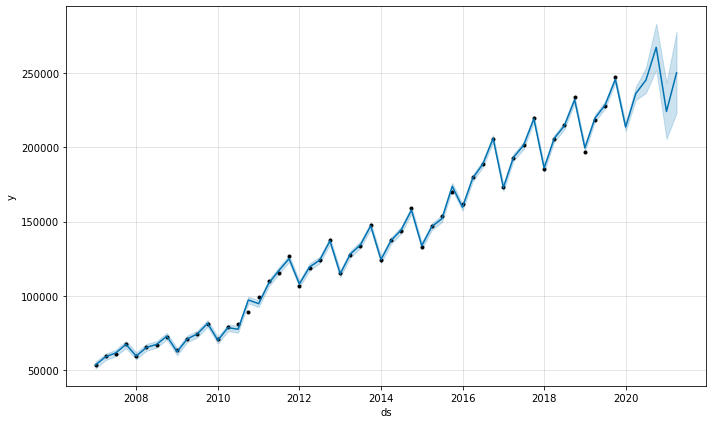

In [ ]:
fig1 = model_Prophet.plot(forecast)

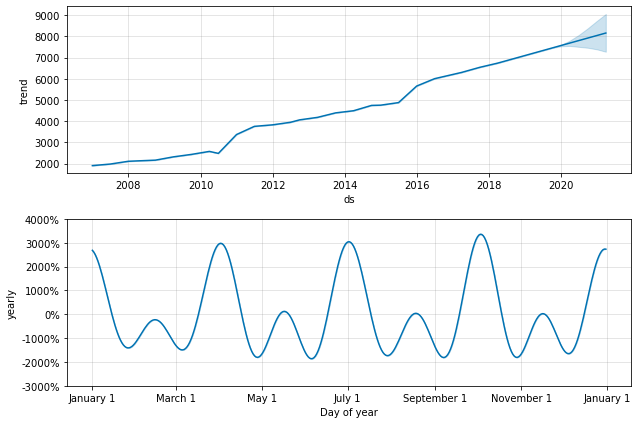

In [ ]:
fig2 = model_Prophet.plot_components(forecast)

In [ ]:
test_data['Predicted_Prophet'] = forecast[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')

<AxesSubplot:xlabel='Date'>

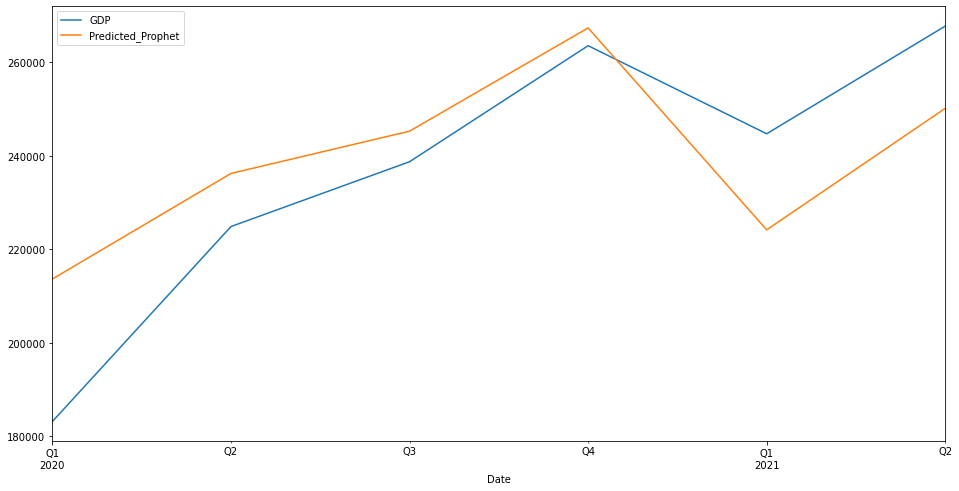

In [ ]:
test_data[[value_col, #'Predicted_ETS' , 'Predicted_ARIMA', 'Predicted_SARIMAX',
           'Predicted_Prophet']].plot(figsize=(16,8))

## Metrics

In [ ]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_ETS)

Evaluation metric results:-
Mean Square Error is : 276718790.97666556
Mean Absolute Error is : 13826.215825263536
Root Mean Square Error is : 16634.866725545642
Mean Absolute Percentage Error is : 6.263352764693329
R2 score is : 0.6505768638959353

Weighted MAPE: 0.05831320254487593


In [ ]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 350294916.9947153
Mean Absolute Error is : 15173.57220454045
Root Mean Square Error is : 18716.167262415544
Mean Absolute Percentage Error is : 6.654187743731277
R2 score is : 0.5576695459473586

Weighted MAPE: 0.06399578890385227


In [ ]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 287337131.8856635
Mean Absolute Error is : 13932.886162317169
Root Mean Square Error is : 16951.021558763456
Mean Absolute Percentage Error is : 6.25889071642359
R2 score is : 0.6371686888762742

Weighted MAPE: 0.05876309346577222


In [ ]:
timeseries_evaluation_metrics_func(test_data.GDP, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 307433684.59800476
Mean Absolute Error is : 15043.958900145488
Root Mean Square Error is : 17533.786944011976
Mean Absolute Percentage Error is : 6.8028322127346
R2 score is : 0.6117920223736403

Weighted MAPE: 0.06344913413097626


### Conclusion:

The best model to predict China Real GDP is the ETS model as it give the smallest WMAPE. 

We also observed that this time series is the only one that all models have positive R2 score. 

Ranking of the models: ETS, SARIMAX, Prophet and ARIMA.

The ranking of the best models are: ETS, SARIMAX, Prophet and ARIMA.